# AI_Spark_Challenge(공기 압축기)

In [ ]:
# !pip install catboost
# !pip install pyod

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV

from imblearn.over_sampling import SMOTE
from keras.layers.rnn import TimeDistributed
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Conv1D, TimeDistributed, GRU, Dropout, Conv1DTranspose, MaxPooling1D, UpSampling1D, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras import backend as K

from catboost import CatBoostClassifier
from pyod.models.abod import ABOD
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, make_scorer, f1_score

from sklearn.manifold import TSN

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 데이터 탐색

In [ ]:
# train 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/dataset/train_data.csv')

# test 데이터 불러오기
test = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/dataset/test_data.csv')

In [ ]:
train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [ ]:
test

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,2.51,53.28,0.7,32.54,2662.0,69.58,3.48,0
1,2.66,55.24,0.7,34.45,2819.0,71.32,3.57,0
2,1.72,42.74,0.7,22.23,1819.0,60.21,3.01,0
3,2.20,49.15,0.7,28.50,2332.0,65.91,3.30,0
4,2.06,47.28,0.7,26.67,2182.0,64.24,3.21,0
...,...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,7
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,7
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,7
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,7


# 2. 데이터 전처리

## 컬럼 추가 & 불필요한 컬럼 삭제

- 필요할 것 같은 컬럼 추가 및 불필요한 컬럼을 주관적으로 판단해 시행해봄 <br>
=> 결론적으로, 성능이 좋아지지 않음 <br>
=> 주어진 데이터 그대로를 사용하는 것이 성능이 더 좋았음 <br>
* '성능을 비교해보기 위한 이러한 작업을 해보았다' 라는 설명 용도

## 새로운 컬럼 추가


In [ ]:
# type 삭제
train_type = train.loc[:, 'type']
train = train.drop('type', axis = 1)
test_type = test.loc[:, 'type']
test = test.drop('type', axis = 1)

In [ ]:
train['1'] = train['motor_current'] * train['out_pressure']
test['1'] = test['motor_current'] * test['out_pressure']

train['2'] = train['air_inflow'] * (train['air_end_temp'] - 25) * 1.2
test['2'] = test['air_inflow'] * (test['air_end_temp'] - 25) * 1.2

train['3'] = train['motor_current'] * train['motor_vibe'] * train['motor_rpm']
test['3'] = test['motor_current'] * test['motor_vibe'] * test['motor_rpm']

# train['1'] = train['motor_current'] * train['motor_voltage'] / train['air_inflow']
# test['1'] = test['motor_current'] * test['motor_voltage'] / test['air_inflow']

# train['2'] = train['out_pressure'] / train['air_inflow']
# test['2'] = test['out_pressure'] / test['air_inflow']

# train['3'] = train['motor_temp'] / train['motor_current']
# test['3'] = test['motor_temp'] / test['motor_current']

# train['4'] = train['motor_rpm'] / train['motor_vibe']
# test['4'] = test['motor_rpm'] / test['motor_vibe']

# train['5'] = train['air_end_temp'] / train['out_pressure']
# test['5'] = test['air_end_temp'] / test['out_pressure']

# train['6'] = train['motor_vibe'] / train['motor_temp']
# test['6'] = test['motor_vibe'] / test['motor_temp']

# train['7'] = train['motor_rpm'] / train['air_inflow']
# test['7'] = test['motor_rpm'] / test['air_inflow']

# train['8'] = train['motor_current'] / train['out_pressure']
# test['8'] = test['motor_current'] / test['out_pressure']

# train['9'] = train['air_end_temp'] / train['air_inflow']
# test['9'] = test['air_end_temp'] / test['air_inflow']

# train['10'] = train['motor_current'] / train['motor_vibe']
# test['10'] = test['motor_current'] / test['motor_vibe']

In [ ]:
train['type'] = train_type
test['type'] = test_type

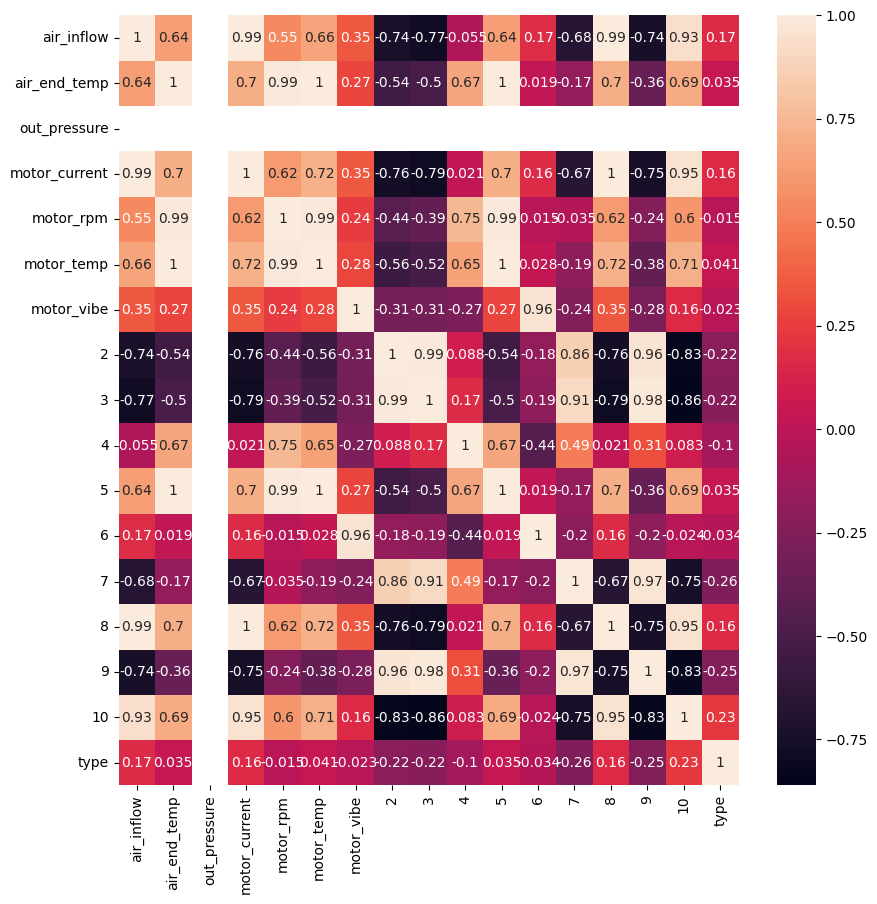

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(train.corr(), annot = True)
plt.show()

In [ ]:
# 마력 추가
train["type_weight"] = train["type"].map({0: 30, 1: 20, 2: 10, 3: 50, 4: 30, 5: 30, 6: 30, 7: 30})
test["type_weight"] = test["type"].map({0: 30, 1: 20, 2: 10, 3: 50, 4: 30, 5: 30, 6: 30, 7: 30})

In [ ]:
# 불필요한 컬럼 제거 (out_pressure)
# train = train.drop(['out_pressure'], axis = 1)
# test = test.drop(['out_pressure'], axis = 1)

In [ ]:
train = train.drop(['air_end_temp','motor_temp'], axis = 1)
test = test.drop(['air_end_temp','motor_temp'], axis = 1)

In [ ]:
# 이상치 제거
train = train.loc[train['motor_vibe'] < 20]

In [ ]:
target = 'type'

x = train.drop(target, axis = 1)
y = train.loc[:, target]

## 변수 중요도
* 위에서 주관적으로 생각하고 불필요한 컬럼을 삭제해본 결과 성능이 좋지않았음 <br>
따라서, catboost로 변수 중요도에 따라 불필요한 컬럼을 확인해보자 함

In [ ]:
model = CatBoostClassifier()

model.fit(x_train, y_train)

y_pred = model.predict(x_val)

print('---------------------------------------------------------------------')
print(confusion_matrix(y_val, y_pred))
print('---------------------------------------------------------------------')
print(classification_report(y_val, y_pred))
print('---------------------------------------------------------------------')
print(accuracy_score(y_val, y_pred))
print('---------------------------------------------------------------------')

Learning rate set to 0.081883
0:	learn: 1.8860841	total: 14.6ms	remaining: 14.6s
1:	learn: 1.7673842	total: 29.1ms	remaining: 14.5s
2:	learn: 1.6833262	total: 37.7ms	remaining: 12.5s
3:	learn: 1.6000109	total: 45.8ms	remaining: 11.4s
4:	learn: 1.5386572	total: 54ms	remaining: 10.7s
5:	learn: 1.4922950	total: 62ms	remaining: 10.3s
6:	learn: 1.4451055	total: 70.3ms	remaining: 9.97s
7:	learn: 1.3989797	total: 78.3ms	remaining: 9.71s
8:	learn: 1.3631739	total: 86.4ms	remaining: 9.51s
9:	learn: 1.3311623	total: 94.4ms	remaining: 9.34s
10:	learn: 1.3048963	total: 102ms	remaining: 9.17s
11:	learn: 1.2800499	total: 111ms	remaining: 9.17s
12:	learn: 1.2513969	total: 120ms	remaining: 9.08s
13:	learn: 1.2320781	total: 128ms	remaining: 9s
14:	learn: 1.2080160	total: 136ms	remaining: 8.92s
15:	learn: 1.1912987	total: 144ms	remaining: 8.87s
16:	learn: 1.1715665	total: 155ms	remaining: 8.97s
17:	learn: 1.1544193	total: 170ms	remaining: 9.26s
18:	learn: 1.1402430	total: 178ms	remaining: 9.21s
19:	lear

In [ ]:
y = y.replace([0,4,5,6,7], -1)
y = y.replace(-1,0)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 2023, stratify=y)

In [ ]:
model = CatBoostClassifier()

model.fit(x_train, y_train)

y_pred = model.predict(x_val)

print('---------------------------------------------------------------------')
print(confusion_matrix(y_val, y_pred))
print('---------------------------------------------------------------------')
print(classification_report(y_val, y_pred))
print('---------------------------------------------------------------------')
print(accuracy_score(y_val, y_pred))
print('---------------------------------------------------------------------')

Learning rate set to 0.081911
0:	learn: 1.1838003	total: 79ms	remaining: 1m 18s
1:	learn: 1.0228550	total: 99.4ms	remaining: 49.6s
2:	learn: 0.8950519	total: 124ms	remaining: 41.3s
3:	learn: 0.7922461	total: 146ms	remaining: 36.3s
4:	learn: 0.7051146	total: 166ms	remaining: 33s
5:	learn: 0.6306231	total: 188ms	remaining: 31.2s
6:	learn: 0.5654985	total: 216ms	remaining: 30.7s
7:	learn: 0.5106759	total: 239ms	remaining: 29.6s
8:	learn: 0.4624198	total: 259ms	remaining: 28.5s
9:	learn: 0.4188667	total: 281ms	remaining: 27.8s
10:	learn: 0.3800763	total: 302ms	remaining: 27.1s
11:	learn: 0.3476588	total: 324ms	remaining: 26.6s
12:	learn: 0.3179498	total: 352ms	remaining: 26.7s
13:	learn: 0.2912370	total: 381ms	remaining: 26.8s
14:	learn: 0.2679885	total: 403ms	remaining: 26.5s
15:	learn: 0.2458674	total: 428ms	remaining: 26.3s
16:	learn: 0.2259822	total: 452ms	remaining: 26.1s
17:	learn: 0.2081283	total: 471ms	remaining: 25.7s
18:	learn: 0.1912937	total: 491ms	remaining: 25.3s
19:	learn: 0

In [ ]:
model = CatBoostClassifier()

model.fit(x, y)

Learning rate set to 0.082849
0:	learn: 1.1724173	total: 19.1ms	remaining: 19.1s
1:	learn: 1.0091312	total: 33.4ms	remaining: 16.7s
2:	learn: 0.8805986	total: 48.3ms	remaining: 16s
3:	learn: 0.7808318	total: 58.2ms	remaining: 14.5s
4:	learn: 0.6946064	total: 68.1ms	remaining: 13.5s
5:	learn: 0.6197974	total: 78.2ms	remaining: 12.9s
6:	learn: 0.5569517	total: 88ms	remaining: 12.5s
7:	learn: 0.5020072	total: 97.9ms	remaining: 12.1s
8:	learn: 0.4541803	total: 109ms	remaining: 12s
9:	learn: 0.4106434	total: 119ms	remaining: 11.7s
10:	learn: 0.3720181	total: 129ms	remaining: 11.6s
11:	learn: 0.3393682	total: 138ms	remaining: 11.4s
12:	learn: 0.3087565	total: 150ms	remaining: 11.4s
13:	learn: 0.2821363	total: 159ms	remaining: 11.2s
14:	learn: 0.2593826	total: 170ms	remaining: 11.1s
15:	learn: 0.2374920	total: 179ms	remaining: 11s
16:	learn: 0.2178640	total: 189ms	remaining: 10.9s
17:	learn: 0.2001675	total: 202ms	remaining: 11s
18:	learn: 0.1843659	total: 213ms	remaining: 11s
19:	learn: 0.16

In [ ]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

,feature_name,feature_importance
0,7,30.972620
1,6,29.156202
2,9,28.881787
3,motor_vibe,2.820157
4,10,2.733358
5,3,2.038618
6,4,1.095361
7,motor_rpm,0.616725
8,air_end_temp,0.415398
9,2,0.383767


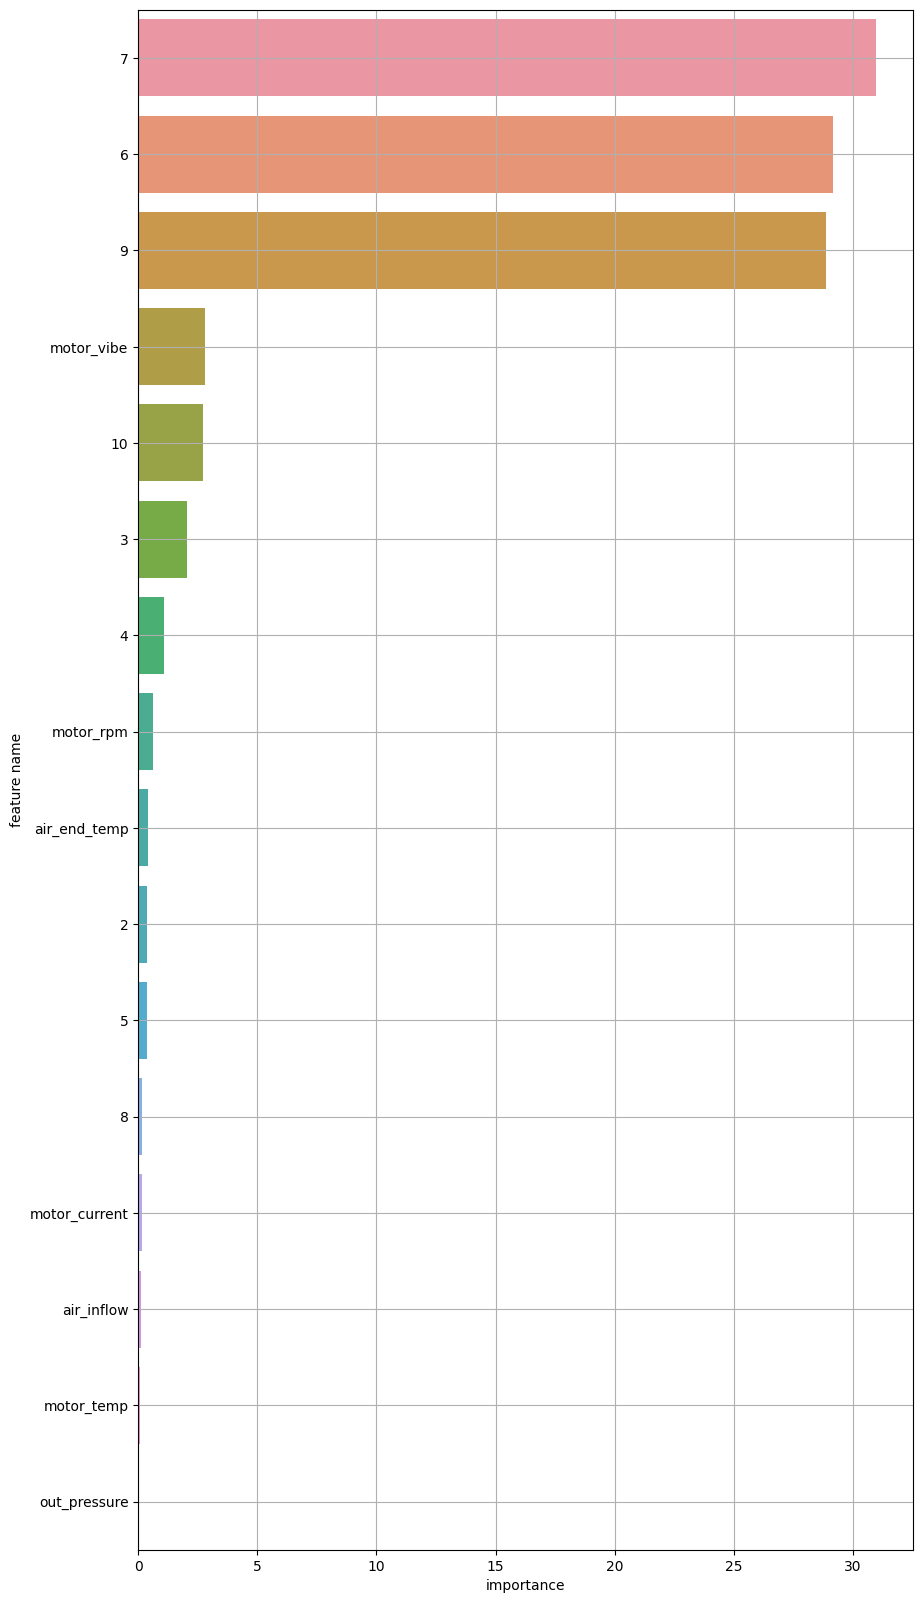

In [ ]:
plot_feature_importance(model.feature_importances_, x.columns)

In [ ]:
train_1 = train[train['type'] == 1].iloc[:, :-1]
test_1 = test[test['type'] == 1].iloc[:, :-1]
train_1

,air_inflow,motor_current,motor_rpm,motor_temp,motor_vibe
432,1.73,25.60,2973.0,71.03,3.45
433,1.31,19.32,2244.0,62.93,3.05
434,1.33,19.69,2287.0,63.41,3.07
435,1.87,27.56,3200.0,73.56,3.58
436,1.68,24.78,2878.0,69.98,3.40
...,...,...,...,...,...
796,0.72,10.56,1226.0,51.62,2.48
797,0.86,12.68,1473.0,54.37,2.62
798,0.83,12.31,1430.0,53.89,2.59
799,1.77,26.07,3028.0,71.64,3.48


## SMOTE
* 데이터 불균형을 해결해보기 위함
* 성능이 좋아지지 않음 => 성능 비교를 위한 작업을 설명하는 용도

In [ ]:
target = 'type'

x = train.drop (target, axis = 1)
y = train.loc[:, target]

# 3. 모델링

## 모델1) Auto Encoder

In [ ]:
# auto encoder용 SMOTE
target = 'type'
y = train.loc[:, target]

smote = SMOTE(random_state=42)
train, y = smote.fit_resample(train, y)

In [ ]:
clear_session()

train_1 = train[train['type'] == 1].iloc[:, :-1]
test_1 = test[test['type'] == 1].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_1)
test_scaled = scaler.transform(test_1)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])


def ae_model(X):

    # Define generator model
    generator_input = Input(shape=(X.shape[1], X.shape[2]))
    generator_dense = Dense(128, activation='relu')(generator_input)
    generator_output = Dense(X.shape[1])(generator_dense)
    generator = Model(generator_input, generator_output)

    # Define discriminator model
    discriminator_input = Input(shape=(X.shape[1], X.shape[2]))
    discriminator_dense = Dense(128, activation='relu')(discriminator_input)
    discriminator_output = Dense(X.shape[1])(discriminator_dense)
    discriminator = Model(discriminator_input, discriminator_output)

    # Compile discriminator model
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

    # Define GAN model
    gan_input = Input(shape=(X.shape[1], X.shape[2]))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)

    # Compile GAN model
    gan.compile(loss='binary_crossentropy', optimizer=Adam())

    return gan



# # 최종 코드
# def ae_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L = Conv1D(filters=512,
#                kernel_size=64,
#                padding='same',
#                data_format='channels_last',
#                dilation_rate=1,
#                activation="linear")(inputs)
#     L0 = Dense(128)(L)
#     L1 = LSTM(64, activation='relu', return_sequences=False)(L0)
#     L2 = Dense(64)(L1)
#     encoded = RepeatVector(X.shape[1])(L2)
#     L3 = Dense(64)(encoded)
#     L4 = LSTM(64, activation='relu', return_sequences=True)(L3)
#     L5 = Dense(128)(L4)
#     L6 = Conv1D(filters=512,
#                kernel_size=64,
#                padding='same',
#                data_format='channels_last',
#                dilation_rate=1,
#                activation="linear")(L5)
#     decoded = Dense(X.shape[2], activation=None)(L6)

#     model = Model(inputs, decoded)

#     return model

# # LSTM AE 모델 구축
# def ae_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(64, activation='relu', return_sequences=True,
#             kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(64, activation='relu', return_sequences=True,
#             kernel_regularizer=regularizers.l2(0.00))(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)

#     model = Model(inputs, output)
#     return model


# 모델 컴파일
# model = ae_model(train_scaled)
# model.compile(optimizer=Adam(), loss='mse')

model = ae_model(train_scaled)
model.compile(optimizer=Adam(), loss='binary_crossentropy')

# callbacks
es = EarlyStopping(monitor = 'val_loss',
                  patience = 10,
                  verbose = 1,
                  restore_best_weights = True)

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=500, batch_size=32, validation_split=0.1, callbacks=[es]).history

# 시각화
#fig, ax = plt.subplots(figsize=(14, 6), dpi=400)
#ax.plot(history['loss'], 'b', label='Train')
#ax.plot(history['val_loss'], 'r', label='Validation')
#ax.set_title('Model loss')
#ax.set_ylabel('Loss (mse)')
#ax.set_xlabel('Epochs')
#ax.legend()
#plt.show()

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_1.columns)
train_pred.index = train_1.index

scored = pd.DataFrame(index=train_1.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.square(train_pred - Xtrain), axis=1)
#scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)

# test 재구성 오차
threshold = np.percentile(scored, 100)

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_1.columns)
test_pred.index = test_1.index

test_scored = pd.DataFrame(index=test_1.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.square(test_pred - Xtest), axis=1)
#test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

In [ ]:
test_scored['Anomaly'].value_counts()

0    1107
Name: Anomaly, dtype: int64

In [ ]:
# 결과
result = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/dataset/answer_sample.csv')
result_1 = result[result['type'] == 1]
result_1['label'] = test_scored['Anomaly'].values

In [ ]:
clear_session()

train_2 = train[train['type'] == 2].iloc[:, :-1]
test_2 = test[test['type'] == 2].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_2)
test_scaled = scaler.transform(test_2)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])

# 모델 컴파일
model = ae_model(train_scaled)
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# callbacks
es = EarlyStopping(monitor = 'val_loss',
                  patience = 7,
                  verbose = 1,
                  restore_best_weights = True)

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es]).history

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_2.columns)
train_pred.index = train_2.index

scored = pd.DataFrame(index=train_2.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.square(train_pred - Xtrain), axis=1)
#scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)


# test 재구성 오차
threshold = np.percentile(scored, 100)

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_2.columns)
test_pred.index = test_2.index

test_scored = pd.DataFrame(index=test_2.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.square(test_pred - Xtest), axis=1)
#test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

Epoch 1/100
11/11 [==============================] - 3s 87ms/step - loss: 0.2055 - val_loss: 0.0809
Epoch 2/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0556 - val_loss: 0.0287
Epoch 3/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0214 - val_loss: 0.0047
Epoch 4/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 7.7999e-04
Epoch 6/100
11/11 [==============================] - 0s 19ms/step - loss: 4.5107e-04 - val_loss: 3.8954e-04
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 2.7316e-04 - val_loss: 1.6458e-04
Epoch 8/100
11/11 [==============================] - 0s 19ms/step - loss: 8.0044e-05 - val_loss: 3.7869e-05
Epoch 9/100
11/11 [==============================] - 0s 19ms/step - loss: 5.1440e-05 - val_loss: 2.3208e-05
Epoch 10/100
11/11 [==============================] - 0s 21ms/st

,Loss_mse,Threshold,Anomaly
2403,7.183571e-06,0.000013,0
2404,3.993188e-06,0.000013,0
2405,9.488361e-06,0.000013,0
2406,3.333124e-07,0.000013,0
2407,4.449116e-06,0.000013,0


In [ ]:
test_scored['Anomaly'].value_counts()

0    1066
1      32
Name: Anomaly, dtype: int64

In [ ]:
# 결과
result_2 = result[result['type'] == 2]
result_2['label'] = test_scored['Anomaly'].values

In [ ]:
clear_session()

train_3 = train[train['type'] == 3].iloc[:, :-1]
test_3 = test[test['type'] == 3].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_3)
test_scaled = scaler.transform(test_3)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])

# 모델 컴파일
model = ae_model(train_scaled)
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# callbacks
es = EarlyStopping(monitor = 'val_loss',
                  patience = 7,
                  verbose = 1,
                  restore_best_weights = True)

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es]).history

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_3.columns)
train_pred.index = train_3.index

scored = pd.DataFrame(index=train_3.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.square(train_pred - Xtrain), axis=1)
#scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)

# test 재구성 오차
threshold = np.percentile(scored, 100)

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_3.columns)
test_pred.index = test_3.index

test_scored = pd.DataFrame(index=test_3.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.square(test_pred - Xtest), axis=1)
#test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

Epoch 1/100
9/9 [==============================] - 4s 109ms/step - loss: 0.2811 - val_loss: 0.0320
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0497 - val_loss: 0.0389
Epoch 3/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0327 - val_loss: 0.0203
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0134 - val_loss: 0.0067
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 6/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 7/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 7.8381e-04
Epoch 8/100
9/9 [==============================] - 0s 19ms/step - loss: 4.3064e-04 - val_loss: 3.0982e-04
Epoch 9/100
9/9 [==============================] - 0s 19ms/step - loss: 3.2217e-04 - val_loss: 4.0609e-04
Epoch 10/100
9/9 [==============================] - 0s 19ms/step - loss: 1.9651e-04 - val_loss: 7

,Loss_mse,Threshold,Anomaly
3501,0.000006,0.000024,0
3502,0.000002,0.000024,0
3503,0.000009,0.000024,0
3504,0.000004,0.000024,0
3505,0.000008,0.000024,0


In [ ]:
test_scored['Anomaly'].value_counts()

0    890
1     28
Name: Anomaly, dtype: int64

In [ ]:
# 결과
result_3 = result[result['type'] == 3]
result_3['label'] = test_scored['Anomaly'].values

In [ ]:
clear_session()

train_4 = train[train['type'].isin([0, 4, 5, 6, 7])].iloc[:, :-1]
test_4 = test[test['type'].isin([0, 4, 5, 6, 7])].iloc[:, :-1]

# 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_4)
test_scaled = scaler.transform(test_4)

# reshape
train_scaled = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
test_scaled = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])

# 모델 컴파일
model = ae_model(train_scaled)
model.compile(optimizer=Adam(lr=0.001), loss='mse')

# callbacks
es = EarlyStopping(monitor = 'val_loss',
                  patience = 7,
                  verbose = 1,
                  restore_best_weights = True)

# 모델 학습
history = model.fit(train_scaled, train_scaled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es]).history

# train 재구성 오차를 계산합니다.
train_pred = model.predict(train_scaled)
train_pred = train_pred.reshape(train_pred.shape[0], train_pred.shape[2])
train_pred = pd.DataFrame(train_pred, columns=train_4.columns)
train_pred.index = train_4.index

scored = pd.DataFrame(index=train_4.index)
Xtrain = train_scaled.reshape(train_scaled.shape[0], train_scaled.shape[2])
scored['Loss_mse'] = np.mean(np.square(train_pred - Xtrain), axis=1)
#scored['Loss_mse'] = np.mean(np.abs(train_pred - Xtrain), axis=1)

# test 재구성 오차
threshold = np.percentile(scored, 100)

test_pred = model.predict(test_scaled)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
test_pred = pd.DataFrame(test_pred, columns=test_4.columns)
test_pred.index = test_4.index

test_scored = pd.DataFrame(index=test_4.index)
Xtest = test_scaled.reshape(test_scaled.shape[0], test_scaled.shape[2])
test_scored['Loss_mse'] = np.mean(np.square(test_pred - Xtest), axis=1)
#test_scored['Loss_mse'] = np.mean(np.abs(test_pred - Xtest), axis=1)
test_scored['Threshold'] = threshold
test_scored['Anomaly'] = test_scored['Loss_mse'] > test_scored['Threshold']

test_scored['Anomaly'] = test_scored['Anomaly'].replace(False, 0)
test_scored['Anomaly'] = test_scored['Anomaly'].replace(True, 1)
test_scored.head()

Epoch 1/100
40/40 [==============================] - 4s 34ms/step - loss: 0.0870 - val_loss: 0.0088
Epoch 2/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0031 - val_loss: 1.9750e-04
Epoch 3/100
40/40 [==============================] - 1s 14ms/step - loss: 1.1351e-04 - val_loss: 2.0368e-05
Epoch 4/100
40/40 [==============================] - 1s 15ms/step - loss: 1.1450e-05 - val_loss: 6.1539e-06
Epoch 5/100
40/40 [==============================] - 1s 16ms/step - loss: 3.8808e-06 - val_loss: 2.2131e-06
Epoch 6/100
40/40 [==============================] - 1s 15ms/step - loss: 2.1300e-06 - val_loss: 1.5238e-06
Epoch 7/100
40/40 [==============================] - 1s 15ms/step - loss: 1.4630e-06 - val_loss: 1.1291e-06
Epoch 8/100
40/40 [==============================] - 1s 14ms/step - loss: 1.2886e-06 - val_loss: 1.1511e-06
Epoch 9/100
40/40 [==============================] - 1s 15ms/step - loss: 1.1607e-06 - val_loss: 1.0423e-06
Epoch 10/100
40/40 [====================

,Loss_mse,Threshold,Anomaly
0,7.624349e-07,0.000003,0
1,1.717675e-06,0.000003,0
2,4.217396e-07,0.000003,0
3,2.078489e-06,0.000003,0
4,3.863218e-07,0.000003,0


In [ ]:
test_scored['Anomaly'].value_counts()

0    3982
1     284
Name: Anomaly, dtype: int64

### 결과 저장

In [ ]:
# 결과
result_0 = result[result['type'].isin([0, 4, 5, 6, 7])]
result_0['label'] = test_scored['Anomaly'].values

In [ ]:
final = pd.concat([result_0, result_1], axis=0).sort_index()
final = pd.concat([final, result_2], axis=0).sort_index()
final = pd.concat([final, result_3], axis=0).sort_index()

In [ ]:
final.to_csv('autoencoder_final.csv', index=False)

### 가장 성능 좋은 것과 비교

In [ ]:
# 비교
joo = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/answer1398-1445.csv')

In [ ]:
cnt = 0
diff_idx = []
for i in range(len(list(joo['label'].values))):
    if list(joo['label'].values)[i] != list(final['label'].values)[i]:
        cnt += 1
        diff_idx.append(i)
cnt

62

In [ ]:
final.iloc[diff_idx, :]

,type,label
1395,1,0
1396,1,0
1397,1,0
1398,1,0
1399,1,0
...,...,...
4919,4,0
4920,4,0
4921,4,0
4922,4,0


In [ ]:
final[final['label'] == 1]['label'].index

Int64Index([ 585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
            ...
            6796, 6797, 6798, 6799, 6800, 7089, 7342, 7348, 7359, 7360],
           dtype='int64', length=350)

In [ ]:
joo[joo['label'] == 1]['label'].index

Int64Index([ 585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
            ...
            6796, 6797, 6798, 6799, 6800, 7089, 7342, 7348, 7359, 7360],
           dtype='int64', length=350)

In [ ]:
# 비교
jun = pd.read_csv('autoencoder_dense_ver1.csv')

FileNotFoundError: ignored

In [ ]:
cnt = 0
diff_idx = []
for i in range(len(list(jun['label'].values))):
    if list(jun['label'].values)[i] != list(joo['label'].values)[i]:
        cnt += 1
        diff_idx.append(i)
cnt

In [ ]:
final.iloc[diff_idx, :]

## 모델2) ABOD

In [ ]:
# type별 데이터 분리

train_1 = train[train['type'] == 1]#.iloc[:, :-1]
test_1 = test[test['type'] == 1]#.iloc[:, :-1]

train_2 = train[train['type'] == 2]#.iloc[:, :-1]
test_2 = test[test['type'] == 2]#.iloc[:, :-1]

train_3 = train[train['type'] == 3]#.iloc[:, :-1]
test_3 = test[test['type'] == 3]#.iloc[:, :-1]

# train_4 = train[train['type'].isin([0, 4, 5, 6, 7])]#.iloc[:, :-1]
# test_4 = test[test['type'].isin([0, 4, 5, 6, 7])]#.iloc[:, :-1]

In [ ]:
# 정규화
scaler = MinMaxScaler()

train_scaled_1 = scaler.fit_transform(train_1)
test_scaled_1 = scaler.transform(test_1)

train_scaled_2 = scaler.fit_transform(train_2)
test_scaled_2 = scaler.transform(test_2)

train_scaled_3 = scaler.fit_transform(train_3)
test_scaled_3 = scaler.transform(test_3)

train_scaled_4 = scaler.fit_transform(train_4)
test_scaled_4 = scaler.transform(test_4)

In [ ]:
# 차원 축소
pca = PCA(n_components=5)

train_scaled_1 = pca.fit_transform(train_scaled_1)
test_scaled_1 = pca.transform(test_scaled_1)

train_scaled_2 = pca.fit_transform(train_scaled_2)
test_scaled_2 = pca.transform(test_scaled_2)

train_scaled_3 = pca.fit_transform(train_scaled_3)
test_scaled_3 = pca.transform(test_scaled_3)

train_scaled_4 = pca.fit_transform(train_scaled_4)
test_scaled_4 = pca.transform(test_scaled_4)

In [ ]:
# def train(train, test):
#     from sklearn.model_selection import GridSearchCV

#     params = {'n_neighbors': [5, 10, 15, 20]}

#     model = ABOD()

#     grid_search = GridSearchCV(model, params, cv=5)
#     grid_search.fit(train)

#     model = ABOD(contamination=0.001, n_neighbors = grid_search.best_params_['n_neighbors'])

#     model.fit(train)
#     model_pred = model.predict(test)

#     model_pred = np.where(model_pred == -1, 0, model_pred)
#     model_pred = np.where(model_pred == 1, 1, model_pred)

#     return model_pred

In [ ]:
def train(train, test):
    model = ABOD(contamination=0.0001,  n_neighbors=40, method = 'fast')
    model.fit(train)
    model_pred = model.predict(test)

    model_pred = np.where(model_pred == -1, 0, model_pred)
    model_pred = np.where(model_pred == 1, 1, model_pred)

    return model_pred

In [ ]:
pred_1 = train(train_scaled_1, test_scaled_1)
pred_2 = train(train_scaled_2, test_scaled_2)
pred_3 = train(train_scaled_3, test_scaled_3)
pred_4 = train(train_scaled_4, test_scaled_4)

In [ ]:
list(pred_1).count(0), list(pred_1).count(1)

(1107, 0)

In [ ]:
list(pred_2).count(0), list(pred_2).count(1)

(1071, 27)

In [ ]:
list(pred_3).count(0), list(pred_3).count(1)

(892, 26)

In [ ]:
list(pred_4).count(0), list(pred_4).count(1)

(3968, 298)

### 결과 저장

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/dataset/answer_sample.csv')

result_1 = result[result['type'] == 1]
result_1['label'] = pred_1

result_2 = result[result['type'] == 2]
result_2['label'] = pred_2

result_3 = result[result['type'] == 3]
result_3['label'] = pred_3

result_4 = result[result['type'].isin([0, 4, 5, 6, 7])]
result_4['label'] = pred_4

In [ ]:
final = pd.concat([result_2, result_3], axis=0).sort_index()

In [ ]:
final = pd.concat([result_1, result_2], axis=0).sort_index()
final = pd.concat([final, result_3], axis=0).sort_index()
final = pd.concat([final, result_4], axis=0).sort_index()

In [ ]:
# type 1 (48개 1로 바꿔줌)
final.loc[1396:1443, 'label'] = 1

In [ ]:
# 파일 저장
final.to_csv('/content/drive/MyDrive/AIVLE/공모전/answer_ABOD_coladd2.csv', index=False)

In [ ]:
final = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/answer_ABOD_coladd.csv')

### 성능 비교

In [ ]:
# 비교
joo = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/answer1398-1445.csv')

In [ ]:
cnt = 0
diff_idx = []
for i in range(len(list(joo['label'].values))):
    if list(joo['label'].values)[i] != list(final['label'].values)[i]:
        cnt += 1
        diff_idx.append(i)
cnt

328

In [ ]:
final.iloc[diff_idx, :]

,type,label
585,0,0
587,0,0
589,0,0
592,0,0
593,0,0
...,...,...
6800,6,0
7342,7,0
7348,7,0
7359,7,0


### 시각화를 통한 이상치 확인

In [ ]:
# testdata : 적용한 데이터(MinMaxScaler 미적용한 걸 넣어주세요!)
# answer : answer.file 양식 그대로 넣어주세요!
# mothod : 'tsne' / 'pca' 차원 축소 방법을 선택해주세요!
# type : 'basic' (전체데이터) / 'part' (type별) / 'both' (전체+type별)
def outlier(testdata, answer, method='tsne', type='basic'):
    scaler = MinMaxScaler()
    tsne = TSNE(n_components=2, random_state=2023)
    pca = PCA(n_components=2, random_state=2023)

    if method=='tsne':
        data_tsne = tsne.fit_transform(scaler.fit_transform(testdata))
        data_tsne = pd.DataFrame(data_tsne)
        data_tsne = pd.concat([data_tsne, answer], axis=1)
        data_tsne['size'] = np.where(data_tsne['label']==1, 10, 2)

        if type=='basic':
            plt.figure(figsize=(20,10))
            sns.scatterplot(x=data_tsne[0], y=data_tsne[1], data=data_tsne, hue='label', style='label', size='size', linewidths=0.3)
            plt.show()
        elif type=='part':
            plt.figure(figsize=(20,30))
            for i in range(8):
                plt.subplot(4,2,i+1)
                sns.scatterplot(x=data_tsne[data_tsne['type']==i][0], y=data_tsne[data_tsne['type']==i][1], data=data_tsne[data_tsne['type']==i], hue='label', style='label', size='size', linewidths=0.3)
                plt.title(f'type {i}')
            plt.show()
        elif type=='both':
            plt.figure(figsize=(20,10))
            sns.scatterplot(x=data_tsne[0], y=data_tsne[1], data=data_tsne, hue='label', style='label', size='size')
            plt.show()
            plt.figure(figsize=(20,30))
            for i in range(8):
                plt.subplot(4,2,i+1)
                sns.scatterplot(x=data_tsne[data_tsne['type']==i][0], y=data_tsne[data_tsne['type']==i][1], data=data_tsne[data_tsne['type']==i], hue='label', style='label', size='size', linewidths=0.3)
                plt.title(f'type {i}')
            plt.show()

    elif method=='pca':
        data_pca = pca.fit_transform(scaler.fit_transform(testdata))
        data_pca = pd.DataFrame(data_pca)
        data_pca = pd.concat([data_pca, answer], axis=1)
        data_pca['size'] = np.where(data_pca['label']==1, 10, 4)

        if type=='basic':
            plt.figure(figsize=(20,10))
            sns.scatterplot(x=data_pca[0], y=data_pca[1], data=data_pca, hue='label', style='label', size='size', linewidths=0.3)
            plt.show()
        elif type=='part':
            plt.figure(figsize=(20,30))
            for i in range(8):
                plt.subplot(4,2,i+1)
                sns.scatterplot(x=data_pca[data_pca['type']==i][0], y=data_pca[data_pca['type']==i][1], data=data_pca[data_pca['type']==i], hue='label', style='label', size='size', linewidths=0.3)
                #plt.xlim([-0.53, -0.48])
                plt.title(f'type {i}')
            plt.show()
        elif type=='both':
            plt.figure(figsize=(20,10))
            sns.scatterplot(x=data_pca[0], y=data_pca[1], data=data_pca, hue='label', style='label', size='size', linewidths=0.3)
            plt.show()
            plt.figure(figsize=(20,30))
            for i in range(8):
                plt.subplot(4,2,i+1)
                sns.scatterplot(x=data_pca[data_pca['type']==i][0], y=data_pca[data_pca['type']==i][1], data=data_pca[data_pca['type']==i], hue='label', style='label', size='size', linewidths=0.3)
                plt.title(f'type {i}')
            plt.show()

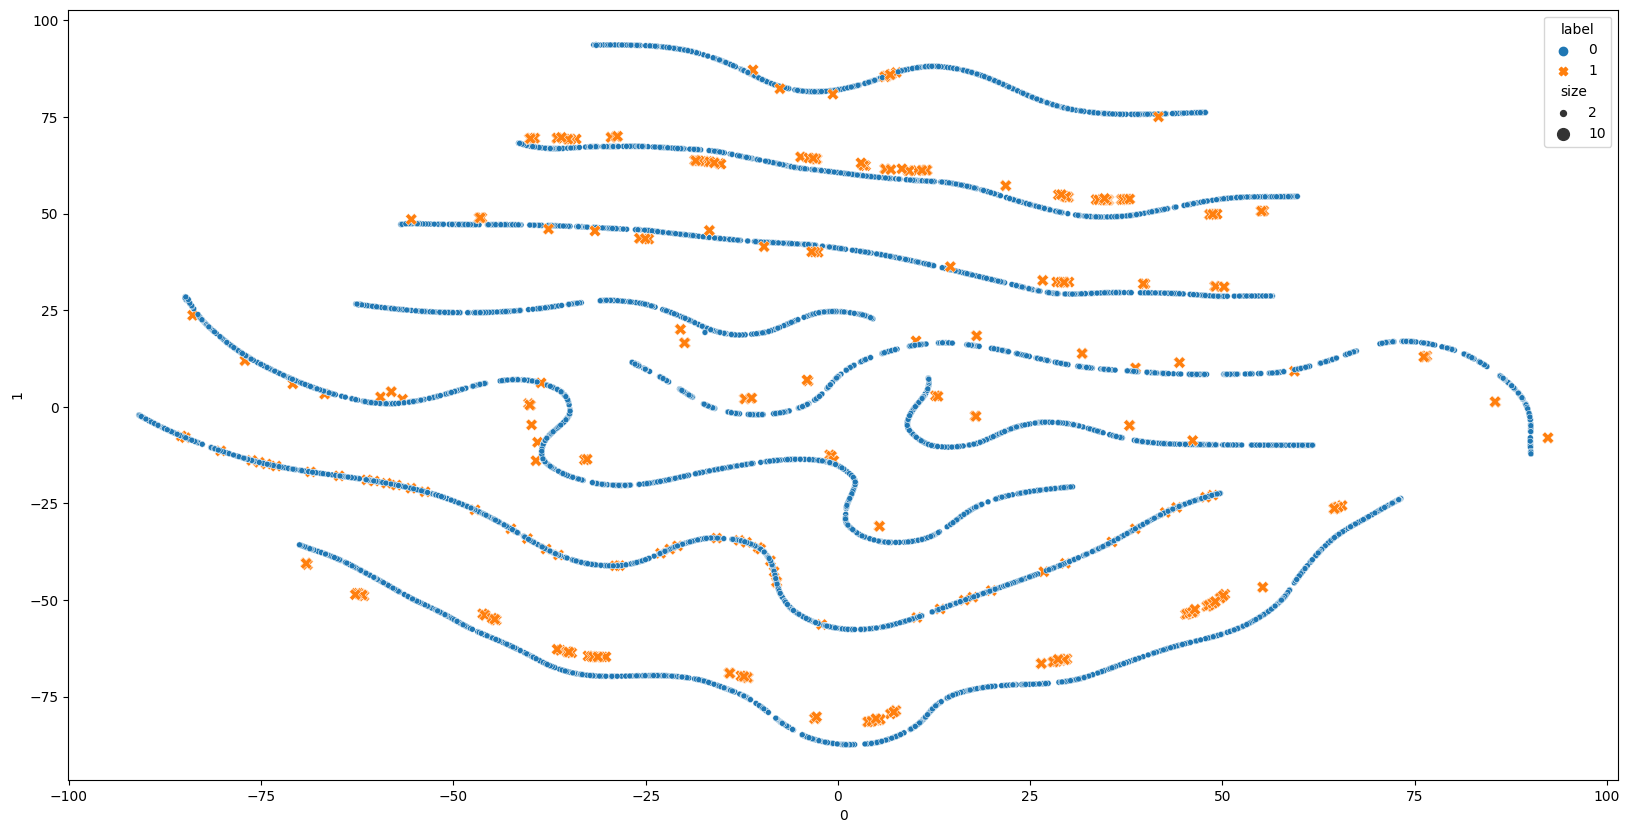

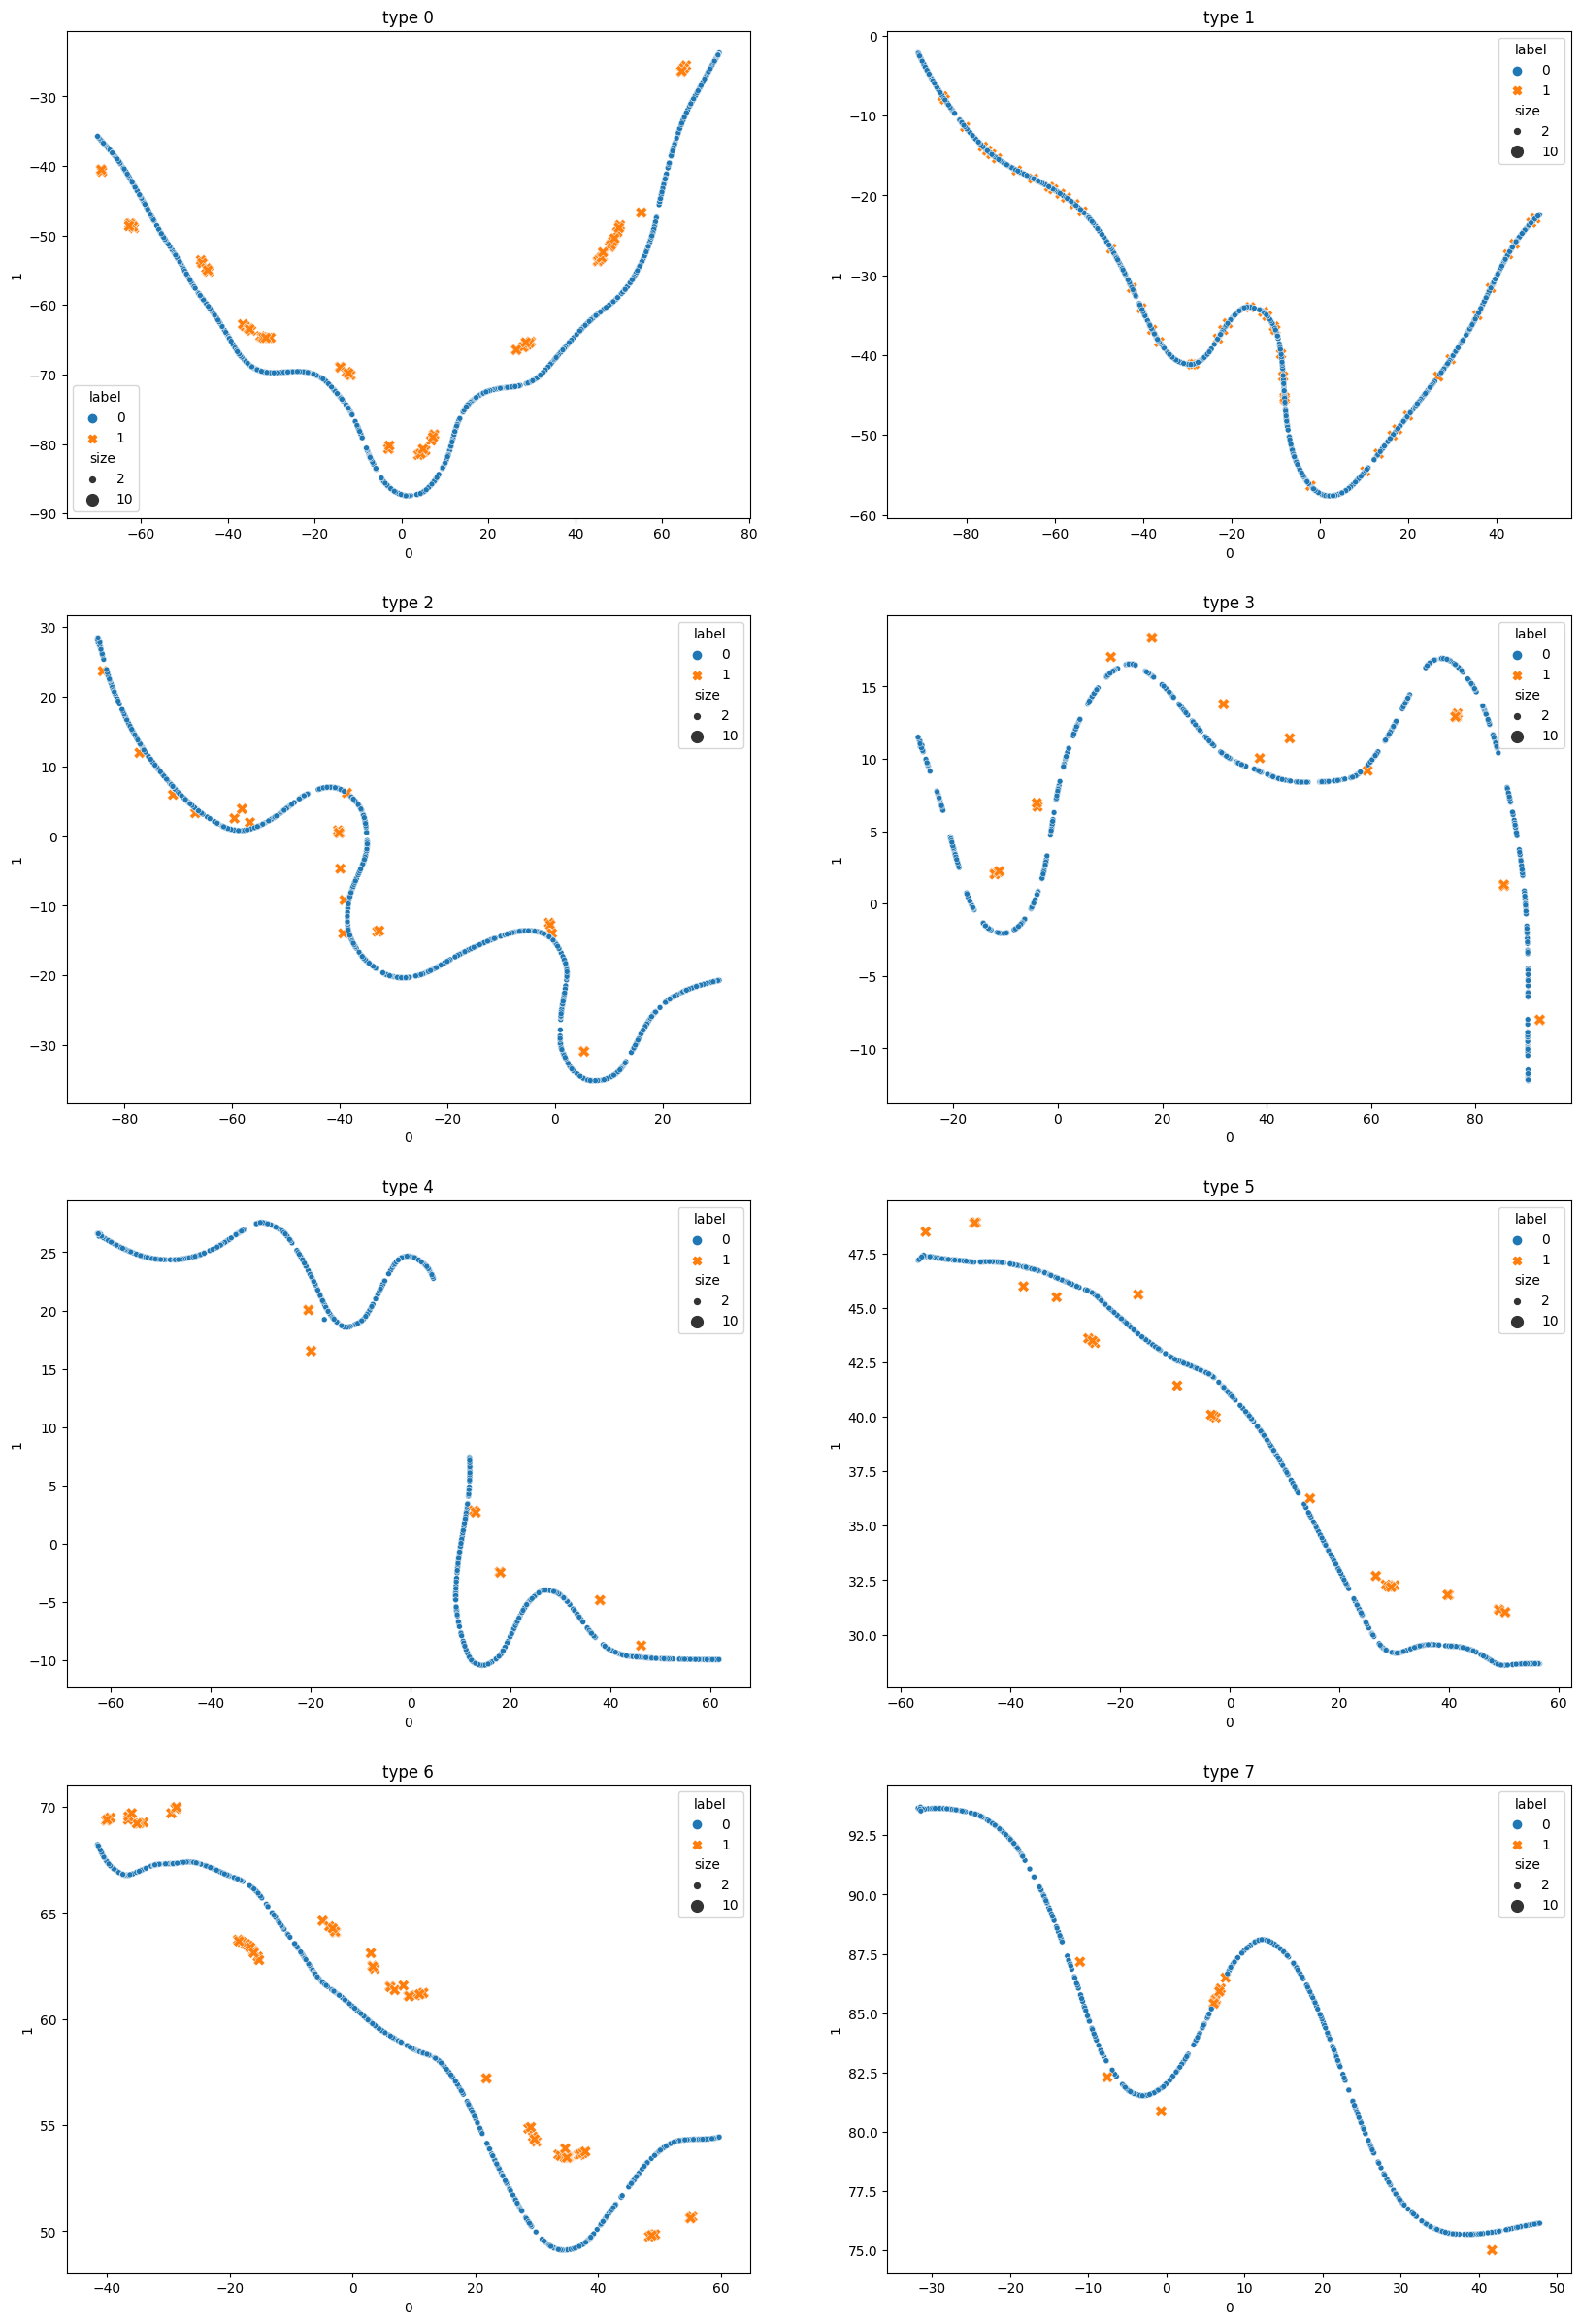

In [ ]:
outlier(test, final, 'tsne', 'both')

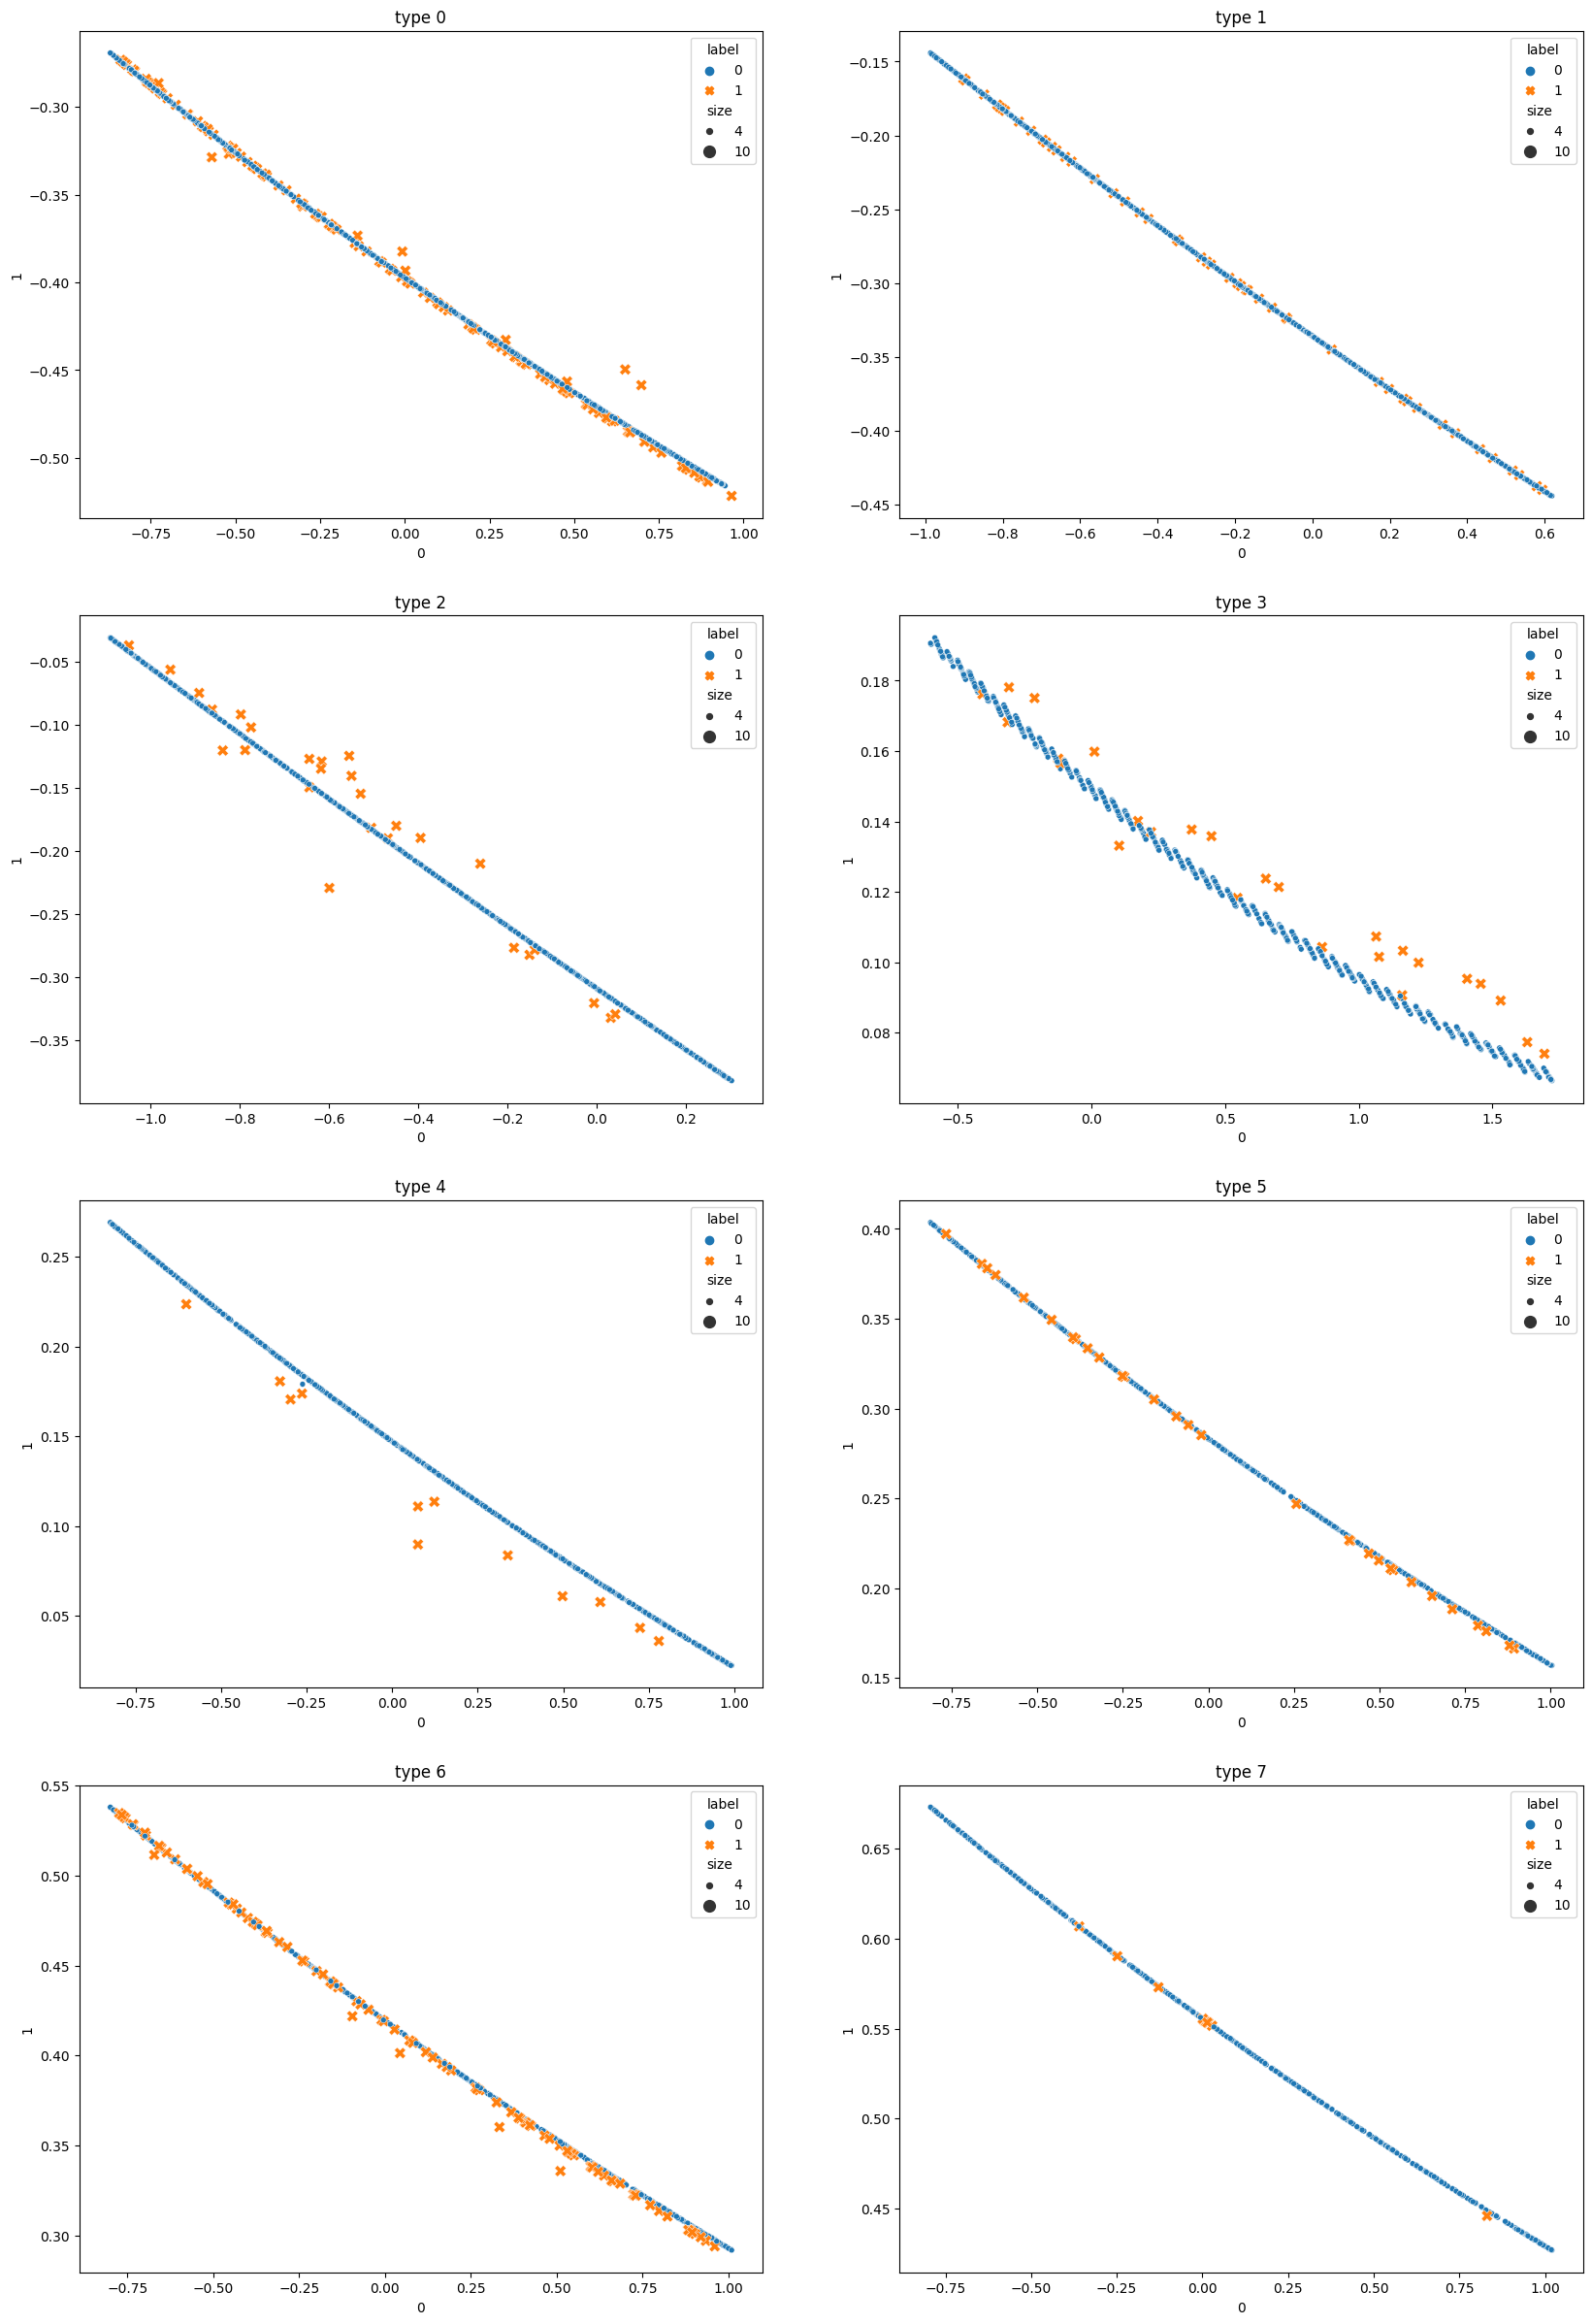

In [ ]:
outlier(test, final, 'pca', 'part')

## 모델3) One Class SVM
* 성능이 좋지 않아서 쓰지 않음

In [ ]:
# train 데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/dataset/train_data.csv')

# test 데이터 불러오기
test_data = pd.read_csv('/content/drive/MyDrive/AIVLE/공모전/dataset/test_data.csv')

In [ ]:
# type별로 train 데이터 구분하기
train_data_by_type = {}
for t in train_data['type'].unique():
    train_data_by_type[t] = train_data[train_data['type']==t].drop('type', axis=1)

In [ ]:
# type별로 test 데이터 구분하기
test_data_by_type = {}
for t in test_data['type'].unique():
    test_data_by_type[t] = test_data[test_data['type']==t].drop('type', axis=1)

In [ ]:
scaler = StandardScaler()
train_data_by_type[1] = scaler.fit_transform(train_data_by_type[1])
test_data_by_type[1] = scaler.transform(test_data_by_type[1])

train_data_by_type[2] = scaler.fit_transform(train_data_by_type[2])
test_data_by_type[2] = scaler.transform(test_data_by_type[2])

train_data_by_type[3] = scaler.fit_transform(train_data_by_type[3])
test_data_by_type[3] = scaler.transform(test_data_by_type[3])

In [ ]:
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'nu': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], # 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
    'gamma': ['scale', 'auto']
}

In [ ]:
models = {}
for t in train_data_by_type.keys():
    model = OneClassSVM()
    scorer = make_scorer(f1_score, pos_label=-1)  # 0 이 비정상 값

    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer)

    grid_search.fit(train_data_by_type[t])

    best_params = grid_search.best_params_
    model.set_params(**best_params)

    model.fit(train_data_by_type[t])

    models[t] = model

In [ ]:
y_pred = {}
for t in train_data_by_type.keys():
    model = models[t]
    y_pred[t] = model.predict(test_data_by_type[t])

In [ ]:
(y_pred[0] == -1).sum()

129

In [ ]:
y_pred[1][:600]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [ ]:
y_pred = {}
for t in test_data['type'].unique():
    test_data_by_type = test_data[test_data['type']==t].drop('type', axis=1)
    model = models[t]
    y_pred[t] = model.predict(test_data_by_type)

In [ ]:
(y_pred[2] == -1).sum()

51

In [ ]:
y_pred[0][600:]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1